In [16]:
import torch

x = torch.arange(4.0, requires_grad=True)
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [17]:
x.requires_grad_(True)
x.grad

In [18]:
y = 2*x@x
y

tensor(28., grad_fn=<DotBackward0>)

In [19]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [20]:
x.grad == 4*x

tensor([True, True, True, True])

In [21]:
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

Backward for Non-Scalar Variables

In [22]:
x.grad.zero_()
y = x * x
y.backward(gradient=torch.ones(len(y)))  # Faster: y.sum().backward()
x.grad
y.sum()

tensor(14., grad_fn=<SumBackward0>)


\begin{equation}
    \nabla y \cdot (1, 1, 1, ..., 1) =  \sum_{i=1}^{n} \frac{\partial y}{\partial x_i}
\end{equation}

Detaching Computation


In [23]:
x.grad.zero_()
y = x * x
u = y.detach() # detaches u from the computational graph
u.requires_grad = True
z = u * x

z.sum().backward()
x.grad, u.grad # yields x^2, # yields x

(tensor([0., 1., 4., 9.]), tensor([0., 1., 2., 3.]))

Note that while this procedure detaches y’s ancestors from the graph leading to z, the computational graph leading to y persists and thus we can calculate the gradient of y with respect to x.

In [24]:
x.grad.zero_()
y.sum().backward()
x.grad
# yields 3x^2

tensor([0., 2., 4., 6.])

Gradients & Python Control Flow

In [25]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [26]:
a = torch.randn(size=(), requires_grad=True) # size = () denotes a scalar tensor whereas size = (1) would be a 1-dimensional tensor
d = f(a)
d.backward()

In [27]:
a.grad == d/a

tensor(True)

Exercises


1. Why is the second derivative much more expensive to compute than the first derivative?

The second derivative is much more expensive because, for a function $f$ with $n$ variables, the Hessian Matrix has $n^2$ elements while the gradient vector has $n$ elements

2. After running the function for backpropagation, immediately run it again and see what happens. Why?

In [28]:
x.grad.zero_()
g = x
g.sum().backward().backward()

AttributeError: 'NoneType' object has no attribute 'backward'

The gradient calculation is based on the chain rule, and calling $\texttt{.backward()}$ twice would involve computing higher-order derivatives, which are not directly supported by PyTorch's autograd. The second call to $\texttt{.backward()}$ would not correctly calculate the second derivative of the objective.

3. In the control flow example where we calculate the derivative of d with respect to a, what would happen if we changed the variable a to a random vector or a matrix? At this point, the result of the calculation $f(a)$ is no longer a scalar. What happens to the result? How do we analyze this?

In [48]:
a = torch.randn(5, requires_grad=True) 
d = f(a)
d.backward(torch.ones_like(a))
a.grad

tensor([ 0.8392, -0.1396,  0.6908,  0.1584,  0.9605])

4. Let $f(x) = \sin(x)$. Plot the graph of $f$ and of its derivative $f'$. Do not exploit the fact that $f'(x) = \cos(x)$
 but rather use automatic differentiation to get the result.

In [30]:
from d2l import torch as d2l

In [31]:
def f(x): 
    return torch.sin(x)

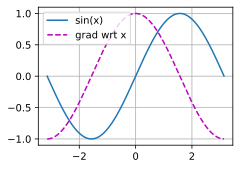

In [35]:
x = torch.arange(-torch.pi,torch.pi,0.01, requires_grad=True)
y = f(x)
y.sum().backward()
d2l.plot(x.detach(), (y.detach(), x.grad), legend=('sin(x)','grad wrt x'))

5. Let $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$. Write out a dependency graph tracing results from $x$ to $f(x)$.

6. Use the chain rule to compute the derivative $\frac{df}{dx}$ of the aforementioned function, placing each term on the dependency graph that you constructed previously.

7. Given the graph and the intermediate derivative results, you have a number of options when computing the gradient. Evaluate the result once starting from $x$ to $f$ and once from  $f$ tracing back to $x$. The path from $x$ to $f$ is commonly known as forward differentiation, whereas the path from $f$ to $x$ is known as backward differentiation.

8. When might you want to use forward differentiation and when backward differentiation? Hint: consider the amount of intermediate data needed, the ability to parallelize steps, and the size of matrices and vectors involved.